In [22]:
using Polynomials
push!(LOAD_PATH, pwd())
using Controlz
using Test
using Gadfly
using DifferentialEquations
using Logging
using DataFrames
using Colors

hipster_theme = Theme(default_color="orange", line_width=1mm, 
    major_label_font_size=14pt, minor_label_font_size=12pt, 
    panel_fill="ivory", minor_label_font="Courier", 
    major_label_font="Courier", point_size=4pt,
    key_label_font_size=12pt, key_label_font="Courier",
    point_shapes=[Shape.xcross, Shape.circle]);

Gadfly.push_theme(hipster_theme)

draw_origin =  [layer(Geom.hline(color="light gray", size=1pt), yintercept=[0.0]),
                layer(Geom.vline(color="light gray", size=1pt), xintercept=[0.0])]

colorz = [colorant"orange", colorant"lime green", colorant"royalblue1"]
discrete_colorz = Scale.color_discrete_manual(colorz...)

set_default_plot_size(7inch, 5inch)

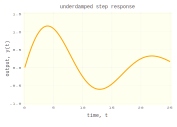

In [23]:
##
# second order, underdamped
K = 4.3
τ = 2.8
ξ = 0.2
g = K / (τ ^ 2 * s ^ 2 + 2 * τ * ξ * s + 1)
# impulse response
t, y = simulate(g, (0.0, 25.0))

function viz_response(t::Array{Float64}, y::Array{Float64}; title::String="")
    return plot(x=t, y=y, Geom.line, 
        Guide.xlabel("time, t"), 
        Guide.ylabel("output, y(t)"),
        Guide.title(title)
    )
end

viz_response(t, y, title="underdamped step response")

In [24]:
g = zeros_poles_gain([2*im, -2*im, 3], [-4, -5, -6], 13.0)

-130.0*s^3 + 390.0*s^2 - 520.0*s + 1560.0
-----------------------------------------
        s^3 + 15*s^2 + 74*s + 120

In [25]:
function zeros_poles_dataframe(tf::TransferFunction)
    z, p, k = zeros_poles_gain(tf)

    df = DataFrame(re=Float64[], im=Float64[], pole_or_zero=String[])
    # load zeros
    for z_i in z
        push!(df, [real(z_i), imag(z_i), "zero"])
    end
    # load poles
    for p_i in p
        push!(df, [real(p_i), imag(p_i), "pole"])
    end
    sort!(df, :pole_or_zero) # necessary for label to be right in Gadfly
    return df
end

zeros_poles_dataframe (generic function with 1 method)

In [26]:
function viz_poles_and_zeros(tf::TransferFunction; coords_fixed::Bool=true)
    df = zeros_poles_dataframe(tf)
    
    return plot(layer(df, x=:re, y=:im, shape=:pole_or_zero, color=:pole_or_zero, hipster_theme),
        Guide.shapekey(title="", labels=sort(unique(df[:, :pole_or_zero]))),
        discrete_colorz,
        Guide.xlabel("Re"),
        Guide.ylabel("Im"),
        draw_origin...,
        Coord.Cartesian(fixed=coords_fixed)
    )
end

viz_poles_and_zeros (generic function with 1 method)

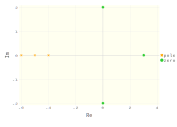

In [27]:
viz_poles_and_zeros(g, coords_fixed=false)

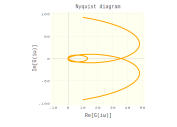

In [28]:
function viz_nyquist_diagram(tf::TransferFunction; nb_pts::Int=200)
    ω = range(-10.0, 10.0, length=nb_pts)

    g_iω = [evaluate(tf, ω_i * im) for ω_i in ω]
    return plot(x=real(g_iω),
         y=imag(g_iω), Geom.path,
         Guide.xlabel("Re[G(iω)]"),
         Guide.ylabel("Im[G(iω)]"),
         Guide.title("Nyquist diagram"),
         Coord.Cartesian(aspect_ratio=1.0),
         draw_origin...
        )
end

viz_nyquist_diagram(g)

In [29]:
function characteristic_polynomial(g_ol::TransferFunction)
    # TODO wut if time delay
    return g_ol.denominator + g_ol.numerator
end

g_ol = 4 / (s + 3) / (s + 2) / (s + 1)
@show g_ol
c_poly = characteristic_polynomial(g_ol)

g_ol =               4.0
--------------------------------
1.0*s^3 + 6.0*s^2 + 11.0*s + 6.0


Poly(10.0 + 11.0*s + 6.0*s^2 + 1.0*s^3)

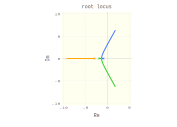

In [31]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)

z, p, k = zeros_poles_gain(g_ol)

# keep gain of G_ol(s) +ve
Kcs = sign(k) * 10.0 .^ range(-6, 2, length=100)
pushfirst!(Kcs, 0.0)

rloc = zeros(Complex, length(Kcs), length(p))

for (i_k, Kc) in enumerate(Kcs)
    c_poly = characteristic_polynomial(Kc * g_ol)
    roots_c_poly = roots(c_poly)
    for i_p = 1:length(roots_c_poly)
        rloc[i_k, i_p] = roots_c_poly[i_p]
    end
end

# df = zeros_poles_dataframe(g_ol)

plot(
    [layer(x=real(rloc[:, i]), y=imag(rloc[:, i]), Geom.path, style(default_color=colorz[i])) for i = 1:length(p)]...,
    [layer(x=[real(p[i])], y=[imag(p[i])], Geom.point, shape=[Shape.xcross],
            style(default_color=colorz[i])
           ) for i = 1:length(p)]...,
    Guide.xlabel("Re"),
    Guide.ylabel("Im"),
    draw_origin...,
    style(key_position=:none),
    Coord.Cartesian(fixed=true),
    Guide.title("root locus")
)

# TODO switch zeros and poles for x's